In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from collections import Counter

from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import pandas as pd

## Data Extraction
We obtain the processed dataset

In [7]:
X = pd.read_csv('X_transformed.csv', encoding='utf-8')
y = pd.read_csv('y_transformed.csv', encoding='utf-8')
y = y.values.ravel()


# Step 2: Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
X_train.shape

(71203, 40)

Normalize the data just in case

In [9]:
# 🔹 3. Normalizar las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Evaluation Metrics

We define a function to retrieve the evaluation metrics for each model

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix

scores = {}

def round_predictions(predictions, threshold=0.5):
    """
    Rounds predictions to integer values from 1 to 5 using a threshold.
    """
    rounded_preds = np.floor(predictions + threshold)  # Apply rounding using the threshold
    return np.clip(rounded_preds, 0, 4)  # Ensure values are within the range [0,4]

def score_metrics(algorithm, prediction, y_test, parameters, threshold=0.5,folder=None,print_res=True):
    # Save raw predictions to a file before rounding
    prediction_df = pd.DataFrame({"Prediction": prediction})
    if folder is not None:
        prediction_df.to_csv(f"{folder}/{algorithm}_predictions.csv", index=False)

    # Apply rounding to predictions
    prediction_rounded = round_predictions(prediction, threshold)

    # Calculate regression metrics
    mae = mean_absolute_error(y_test, prediction_rounded)
    mse = mean_squared_error(y_test, prediction_rounded)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, prediction_rounded)

    # Store results along with the parameters used
    scores[algorithm] = {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2,
        "Threshold": threshold,
        "params": parameters
    }

    # Generate the confusion matrix
    conf_matrix = confusion_matrix(y_test, prediction_rounded, labels=[0, 1, 2, 3, 4])
    if print_res:
    # Print results in a table format
        print(f'''
+---------------------------------------------------+
        {algorithm} - Regression Model Evaluation                         
+---------------------------------------------------+
    MAE  (Mean Absolute Error): {mae:.4f}
    MSE  (Mean Squared Error): {mse:.4f}
    RMSE (Root Mean Squared Error): {rmse:.4f}
    R² Score (Coefficient of Determination): {r2:.4f}
    Threshold used: {threshold}
+---------------------------------------------------+
    ''')
  
    # Row and column labels
        labels = [0, 1, 2, 3, 4]
        plt.figure(figsize=(8,6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

    # Labels and title
        plt.xlabel("Prediction")
        plt.ylabel("Actual Value")
        plt.title("Confusion Matrix")

    # Show the plot
        plt.show()
    
    return conf_matrix


## Train Baseline

In [11]:
import os

# Folder name
folders = ['baseline','tunned_predictions']
for folder in folders:
    # Create the folder if it doesn't exist
    if not os.path.exists(folder):
        os.makedirs(folder)
        print(f"Folder '{folder}' created.")
    else:
        print(f"Folder '{folder}' already exists.")
    

Folder 'baseline' already exists.
Folder 'tunned_predictions' already exists.


In [12]:

# Inicialize models
models = {
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "Linear Regression": LinearRegression(),
    "Neural Network": MLPRegressor(max_iter=500, random_state=42),
    "KNN Regressor": KNeighborsRegressor()
}

# Train models
trained_models = {}
for name, model in models.items():
    print(f"Training {name}...")
    try:
        model.fit(X_train, y_train)
        trained_models[name] = model
        print(f"{name} successfully trained.")
        
        # Make predictions
        predictions = model.predict(X_test)

        # Save predictions in a CSV file
        filename = f"baseline/{name.replace(' ', '_')}_predictions.csv"
        pd.DataFrame(predictions, columns=["Prediction"]).to_csv(filename, index=False)
        print(f"Predictions saved on {filename}.")
    except Exception as e:
        print(f"Failed to train {name}: {e}")

Training Decision Tree...
Decision Tree successfully trained.
Predictions saved on baseline/Decision_Tree_predictions.csv.
Training Random Forest...
Random Forest successfully trained.
Predictions saved on baseline/Random_Forest_predictions.csv.
Training XGBoost...
XGBoost successfully trained.
Predictions saved on baseline/XGBoost_predictions.csv.
Training Linear Regression...
Linear Regression successfully trained.
Predictions saved on baseline/Linear_Regression_predictions.csv.
Training Neural Network...
Neural Network successfully trained.
Predictions saved on baseline/Neural_Network_predictions.csv.
Training KNN Regressor...
KNN Regressor successfully trained.
Predictions saved on baseline/KNN_Regressor_predictions.csv.


## MiniBatch

Due to the large ammount of samples, it would take to much time to gridsearch using all the dataset. To solve this problem we will take a subset of the 10% of the dataset. This subset will be selected to maintain the class proportions from the original dataset. We will do a gridsearch with this subset to obtain the best parameters, then we will use those parameter to train the model with the complete dataset.

In [13]:
X_muestra, _, y_muestra, _ = train_test_split(
    X_train, 
    y_train, 
    train_size=0.1,  # Take 10% of the data
    stratify=y_train,  # Maintain the class proportions
    random_state=42
)

## Training

### Decision Trees

We have seen in the baseline that the basic model has problems, probably due to overfitting. We will add limitations in features and depth to try to solve this.

In [14]:
# Define hyperparameters
params = {
    'max_depth': [4, 6, 8, 10, 12, None],  # Test higher values and None
    'min_samples_split': [150, 200, 500,700,800],  # Increase to avoid overfitting
    'min_samples_leaf': [40, 60,80,100],  # Control the minimum leaf size
    'max_features': ['auto', 'sqrt', 'log2'],  # Limit the number of features
    'criterion': ['squared_error', 'absolute_error']  # Test both criteria
}

# Decision Tree Model for Regression
dt = DecisionTreeRegressor()

# GridSearchCV to optimize hyperparameters
decision_tree = GridSearchCV(dt, param_grid=params, cv=5, verbose=2, n_jobs=-1)

# Train model
decision_tree.fit(X_muestra, y_muestra)
# dt.fit(X_train, y_train)


Fitting 5 folds for each of 720 candidates, totalling 3600 fits
[CV] END criterion=squared_error, max_depth=4, max_features=auto, min_samples_leaf=40, min_samples_split=150; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, max_features=auto, min_samples_leaf=40, min_samples_split=200; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, max_features=auto, min_samples_leaf=40, min_samples_split=200; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, max_features=auto, min_samples_leaf=40, min_samples_split=800; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, max_features=auto, min_samples_leaf=40, min_samples_split=700; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, max_features=auto, min_samples_leaf=40, min_samples_split=800; total time=   0.0s
[CV] END criterion=squared_error, max_depth=4, max_features=auto, min_samples_leaf=40, min_samples_split=500; total time=   0.0s
[CV] END criterion=squared_error,

/home/jaume/miniconda3/envs/cml_env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
1200 fits failed out of a total of 3600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
937 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jaume/miniconda3/envs/cml_env/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jaume/miniconda3/envs/cml_env/lib/python3.10/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/home/jaume/miniconda3/envs/cml_env/lib/python3.10/site-packages/sklearn/base.py", line 436, in _validate_p

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': [4, 6, 8, 10, 12, None],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [40, 60, 80, 100],
                         'min_samples_split': [150, 200, 500, 700, 800]},
             verbose=2)

In [15]:
mejores_parametros = decision_tree.best_params_
mejores_parametros

{'criterion': 'squared_error',
 'max_depth': 6,
 'max_features': 'sqrt',
 'min_samples_leaf': 60,
 'min_samples_split': 200}

In [16]:
# Train with all the dataset
modelo_final_dt = DecisionTreeRegressor(**mejores_parametros)
modelo_final_dt.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=6, max_features='sqrt', min_samples_leaf=60,
                      min_samples_split=200)


+---------------------------------------------------+
        Decision_Tree - Regression Model Evaluation                         
+---------------------------------------------------+
    MAE  (Mean Absolute Error): 0.7798
    MSE  (Mean Squared Error): 1.1128
    RMSE (Root Mean Squared Error): 1.0549
    R² Score (Coefficient of Determination): 0.0978
    Threshold used: 0.5
+---------------------------------------------------+
    


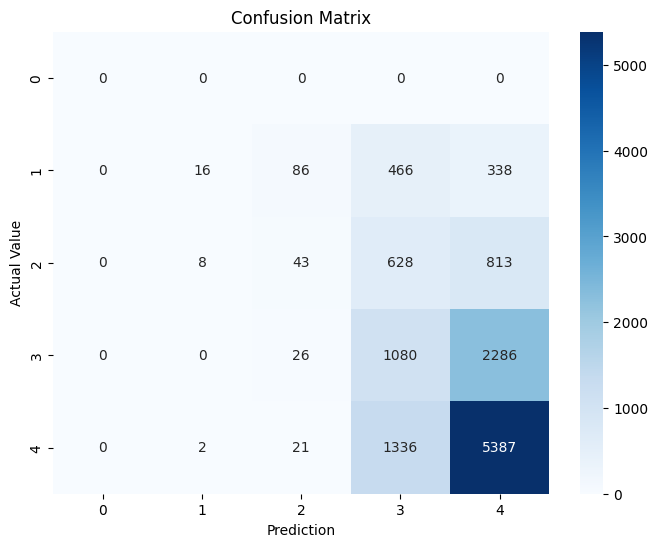

array([[   0,    0,    0,    0,    0],
       [   0,   16,   86,  466,  338],
       [   0,    8,   43,  628,  813],
       [   0,    0,   26, 1080, 2286],
       [   0,    2,   21, 1336, 5387]])

In [17]:
prediction=modelo_final_dt.predict(X_test)
score_metrics("Decision_Tree",prediction,y_test,mejores_parametros,folder="tunned_predictions")

### Random Forest

In [18]:
params_rf = {
    'criterion': ['squared_error'], 
    'bootstrap': [True],
    'max_depth': [5, 10,15, 20],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [2, 3,4],  
    'n_estimators': [500, 600, 800],  
    'random_state': [2]
}

# Random Forest model for regression
rfr = RandomForestRegressor()

# GridSearchCV to find the best hyperparameters
random_forest = GridSearchCV(rfr, param_grid=params_rf, cv=5, verbose=2, n_jobs=-1)

# Train model
random_forest.fit(X_muestra, y_muestra)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END bootstrap=True, criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=3, n_estimators=500, random_state=2; total time=  22.8s
[CV] END bootstrap=True, criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=2; total time=  23.3s
[CV] END bootstrap=True, criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=2; total time=  23.8s
[CV] END bootstrap=True, criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=3, n_estimators=500, random_state=2; total time=  24.0s
[CV] END bootstrap=True, criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=500, random_state=2; total time=  24.1s
[CV] END bootstrap=True, criterion=squared_error, max_depth=5, min_samples_leaf=1, min_samples_split=3, n_estimators=500, random_state=2; total time=  2

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'criterion': ['squared_error'],
                         'max_depth': [5, 10, 15, 20],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [500, 600, 800], 'random_state': [2]},
             verbose=2)

In [19]:
mejores_parametros = random_forest.best_params_
mejores_parametros

{'bootstrap': True,
 'criterion': 'squared_error',
 'max_depth': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 600,
 'random_state': 2}

In [20]:
modelo_final_rf = RandomForestRegressor(**mejores_parametros)
modelo_final_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, min_samples_leaf=3, n_estimators=600,
                      random_state=2)


+---------------------------------------------------+
        Random_Forest - Regression Model Evaluation                         
+---------------------------------------------------+
    MAE  (Mean Absolute Error): 0.7607
    MSE  (Mean Squared Error): 1.0756
    RMSE (Root Mean Squared Error): 1.0371
    R² Score (Coefficient of Determination): 0.1279
    Threshold used: 0.5
+---------------------------------------------------+
    


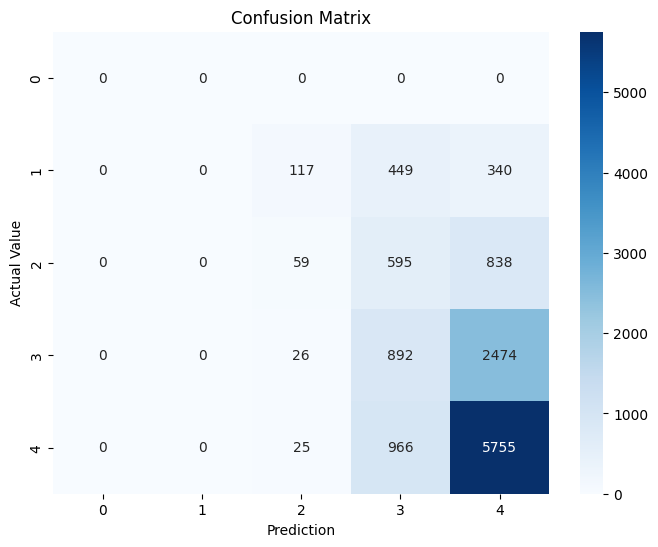

array([[   0,    0,    0,    0,    0],
       [   0,    0,  117,  449,  340],
       [   0,    0,   59,  595,  838],
       [   0,    0,   26,  892, 2474],
       [   0,    0,   25,  966, 5755]])

In [21]:
prediction=random_forest.predict(X_test)
score_metrics("Random_Forest",prediction,y_test,mejores_parametros,folder="tunned_predictions")

### XGBoost

In [22]:
params_xgb = {
    'objective': ['reg:squarederror'],  
    'max_depth': [4,6, 8],  
    'reg_alpha': [2, 2.5, 3.0],  # L1 Regularization
    'eta': [0.01, 0.05, 0.1],  # Learning rate
    'subsample': [0.5,0.6, 0.7, 0.8],  # Controls how much data is used in each tree
    'random_state': [2],
    'eval_metric': ['rmse'], 
    'booster': ['gbtree'] 
}

# Create the XGBoost model for regression
xgbR = XGBRegressor()

# GridSearchCV to find the best hyperparameters
xgboost = GridSearchCV(xgbR, param_grid=params_xgb, cv=5, verbose=2)

# Train the model
xgboost.fit(X_muestra, y_muestra)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END booster=gbtree, eta=0.01, eval_metric=rmse, max_depth=4, objective=reg:squarederror, random_state=2, reg_alpha=2, subsample=0.5; total time=   0.2s
[CV] END booster=gbtree, eta=0.01, eval_metric=rmse, max_depth=4, objective=reg:squarederror, random_state=2, reg_alpha=2, subsample=0.5; total time=   0.3s
[CV] END booster=gbtree, eta=0.01, eval_metric=rmse, max_depth=4, objective=reg:squarederror, random_state=2, reg_alpha=2, subsample=0.5; total time=   0.1s
[CV] END booster=gbtree, eta=0.01, eval_metric=rmse, max_depth=4, objective=reg:squarederror, random_state=2, reg_alpha=2, subsample=0.5; total time=   0.1s
[CV] END booster=gbtree, eta=0.01, eval_metric=rmse, max_depth=4, objective=reg:squarederror, random_state=2, reg_alpha=2, subsample=0.5; total time=   0.1s
[CV] END booster=gbtree, eta=0.01, eval_metric=rmse, max_depth=4, objective=reg:squarederror, random_state=2, reg_alpha=2, subsample=0.6; total time=   

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'booster': ['gbtree'], 'eta': [0.01, 0.05, 0.1],
                         'eval_metric': ['rmse'], 'max_depth': [4, 6, 8],
                         'objective': ['reg:squarederror'], 'random_state': [2],
                         'reg_alpha': [2, 2.5, 3.0],
                         'subsample': [0.5, 0.6, 0.7, 0.8]},
             verbose=2)

In [23]:
mejores_parametros = xgboost.best_params_
mejores_parametros

{'booster': 'gbtree',
 'eta': 0.05,
 'eval_metric': 'rmse',
 'max_depth': 4,
 'objective': 'reg:squarederror',
 'random_state': 2,
 'reg_alpha': 3.0,
 'subsample': 0.5}

In [24]:
# Crear el modelo final con los mejores parámetros
modelo_final_xg = XGBRegressor(**mejores_parametros)

# Entrenar el modelo con todo el dataset
modelo_final_xg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.05, eval_metric='rmse',
             feature_types=None, feature_weights=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None, ...)


+---------------------------------------------------+
        XGBoost - Regression Model Evaluation                         
+---------------------------------------------------+
    MAE  (Mean Absolute Error): 0.7540
    MSE  (Mean Squared Error): 1.0575
    RMSE (Root Mean Squared Error): 1.0283
    R² Score (Coefficient of Determination): 0.1426
    Threshold used: 0.5
+---------------------------------------------------+
    


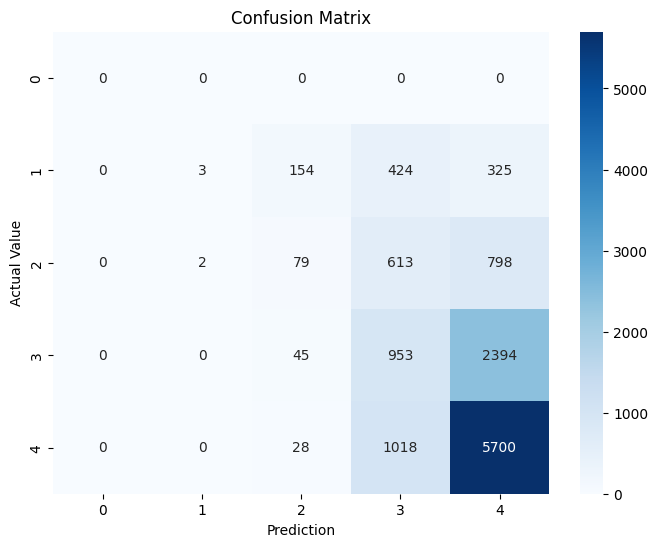

array([[   0,    0,    0,    0,    0],
       [   0,    3,  154,  424,  325],
       [   0,    2,   79,  613,  798],
       [   0,    0,   45,  953, 2394],
       [   0,    0,   28, 1018, 5700]])

In [25]:
prediction=modelo_final_xg.predict(X_test)
#prediction=xgbR.predict(X_test)

score_metrics("XGBoost",prediction,y_test,mejores_parametros,folder="tunned_predictions")

### Linear Regression

In [26]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Ridge Regression
params_ridge = {
    'alpha': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'saga'],
    'fit_intercept': [True, False]
}

# Create Ridge regression model
ridge_model = Ridge()

# GridSearchCV to find the best hyperparameters
ridge_search = GridSearchCV(ridge_model, param_grid=params_ridge, cv=5, verbose=2, n_jobs=-1)

# Train model
ridge_search.fit(X_muestra, y_muestra)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ........alpha=0.01, fit_intercept=True, solver=auto; total time=   0.0s
[CV] END ........alpha=0.01, fit_intercept=True, solver=auto; total time=   0.0s
[CV] END ........alpha=0.01, fit_intercept=True, solver=auto; total time=   0.0s
[CV] END .........alpha=0.01, fit_intercept=True, solver=svd; total time=   0.0s
[CV] END .........alpha=0.01, fit_intercept=True, solver=svd; total time=   0.1s
[CV] END .........alpha=0.01, fit_intercept=True, solver=svd; total time=   0.0s
[CV] END .........alpha=0.01, fit_intercept=True, solver=svd; total time=   0.1s
[CV] END ....alpha=0.01, fit_intercept=True, solver=cholesky; total time=   0.0s
[CV] END .......alpha=0.01, fit_intercept=False, solver=auto; total time=   0.0s
[CV] END .......alpha=0.01, fit_intercept=False, solver=auto; total time=   0.0s
[CV] END .......alpha=0.01, fit_intercept=False, solver=auto; total time=   0.0s[CV] END ....alpha=0.01, fit_intercept=True, sol

/home/jaume/miniconda3/envs/cml_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ........alpha=0.01, fit_intercept=True, solver=saga; total time=   6.0s
[CV] END .........alpha=0.1, fit_intercept=True, solver=saga; total time=   5.8s
[CV] END .........alpha=0.1, fit_intercept=True, solver=saga; total time=   5.8s
[CV] END .........alpha=10, fit_intercept=False, solver=auto; total time=   0.0s
[CV] END .........alpha=10, fit_intercept=False, solver=auto; total time=   0.0s[CV] END ..........alpha=10, fit_intercept=True, solver=saga; total time=   0.6s

[CV] END .........alpha=10, fit_intercept=False, solver=auto; total time=   0.0s
[CV] END .........alpha=10, fit_intercept=False, solver=auto; total time=   0.0s
[CV] END ..........alpha=10, fit_intercept=False, solver=svd; total time=   0.0s
[CV] END ..........alpha=10, fit_intercept=False, solver=svd; total time=   0.0s
[CV] END ..........alpha=10, fit_intercept=False, solver=svd; total time=   0.0s
[CV] END ...........alpha=1, fit_intercept=True, solver=saga; total time=   5.5s
[CV] END ..........alpha=10,

/home/jaume/miniconda3/envs/cml_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jaume/miniconda3/envs/cml_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jaume/miniconda3/envs/cml_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..........alpha=100, fit_intercept=True, solver=svd; total time=   0.0s
[CV] END ........alpha=0.1, fit_intercept=False, solver=saga; total time=   6.2s
[CV] END ..........alpha=100, fit_intercept=True, solver=svd; total time=   0.0s
[CV] END .....alpha=100, fit_intercept=True, solver=cholesky; total time=   0.0s
[CV] END ..........alpha=100, fit_intercept=True, solver=svd; total time=   0.0s
[CV] END .....alpha=100, fit_intercept=True, solver=cholesky; total time=   0.0s
[CV] END .....alpha=100, fit_intercept=True, solver=cholesky; total time=   0.0s
[CV] END .....alpha=100, fit_intercept=True, solver=cholesky; total time=   0.0s
[CV] END ..........alpha=100, fit_intercept=True, solver=svd; total time=   0.0s
[CV] END .....alpha=100, fit_intercept=True, solver=cholesky; total time=   0.0s[CV] END .......alpha=0.01, fit_intercept=False, solver=saga; total time=   6.6s

[CV] END .........alpha=100, fit_intercept=True, solver=lsqr; total time=   0.0s
[CV] END .........alpha=100,

/home/jaume/miniconda3/envs/cml_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jaume/miniconda3/envs/cml_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jaume/miniconda3/envs/cml_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .......alpha=0.01, fit_intercept=False, solver=saga; total time=   7.5s
[CV] END .........alpha=10, fit_intercept=False, solver=saga; total time=   1.4s
[CV] END .........alpha=0.1, fit_intercept=True, solver=saga; total time=   7.5s


/home/jaume/miniconda3/envs/cml_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jaume/miniconda3/envs/cml_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ........alpha=0.01, fit_intercept=True, solver=saga; total time=   8.1s
[CV] END ..........alpha=1, fit_intercept=False, solver=saga; total time=   0.8s
[CV] END .......alpha=0.01, fit_intercept=False, solver=saga; total time=   7.9s
[CV] END .........alpha=10, fit_intercept=False, solver=saga; total time=   1.7s
[CV] END ........alpha=0.01, fit_intercept=True, solver=saga; total time=   7.4s
[CV] END .........alpha=0.1, fit_intercept=True, solver=saga; total time=   8.0s


/home/jaume/miniconda3/envs/cml_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jaume/miniconda3/envs/cml_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jaume/miniconda3/envs/cml_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .........alpha=0.1, fit_intercept=True, solver=saga; total time=   8.1s
[CV] END .........alpha=10, fit_intercept=False, solver=saga; total time=   0.5s
[CV] END ...........alpha=1, fit_intercept=True, solver=saga; total time=   4.6s


/home/jaume/miniconda3/envs/cml_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/jaume/miniconda3/envs/cml_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ..........alpha=1, fit_intercept=False, solver=saga; total time=   4.0s
[CV] END ..........alpha=1, fit_intercept=False, solver=saga; total time=   4.4s
[CV] END ..........alpha=1, fit_intercept=False, solver=saga; total time=   1.7s


/home/jaume/miniconda3/envs/cml_env/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100],
                         'fit_intercept': [True, False],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'saga']},
             verbose=2)

In [27]:
mejores_parametros = ridge_search.best_params_
mejores_parametros

{'alpha': 100, 'fit_intercept': True, 'solver': 'auto'}

In [28]:
# Crear el modelo final con los mejores parámetros
modelo_final_lr = Ridge(**mejores_parametros)

# Entrenar el modelo con todo el dataset
modelo_final_lr.fit(X_train, y_train)


Ridge(alpha=100)


+---------------------------------------------------+
        Linear Regression - Regression Model Evaluation                         
+---------------------------------------------------+
    MAE  (Mean Absolute Error): 0.7575
    MSE  (Mean Squared Error): 1.0748
    RMSE (Root Mean Squared Error): 1.0367
    R² Score (Coefficient of Determination): 0.1286
    Threshold used: 0.5
+---------------------------------------------------+
    


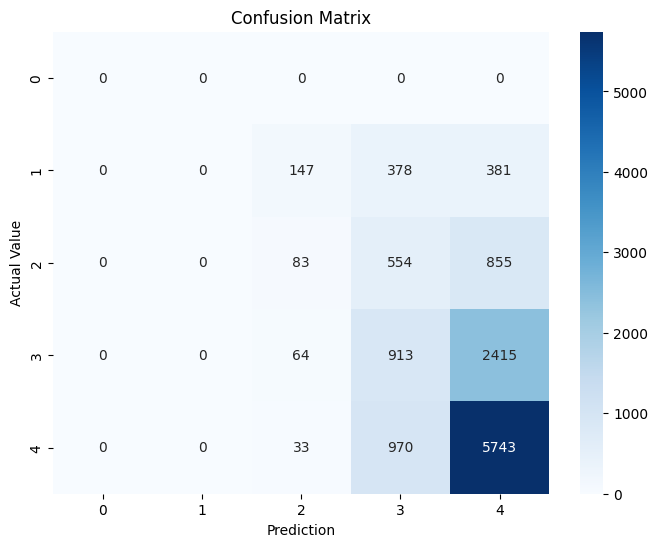

array([[   0,    0,    0,    0,    0],
       [   0,    0,  147,  378,  381],
       [   0,    0,   83,  554,  855],
       [   0,    0,   64,  913, 2415],
       [   0,    0,   33,  970, 5743]])

In [29]:
prediction=modelo_final_lr.predict(X_test)
#prediction=xgbR.predict(X_test)

score_metrics("Linear Regression",prediction,y_test,mejores_parametros,folder="tunned_predictions")

### Neural Network

In [32]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for MLPRegressor
params_nn = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],  # Architecture
    'activation': ['relu', 'tanh'],
    'solver': ['adam'], 
    'alpha': [0.0001, 0.001, 0.01],  # L2 regularization
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [1000,2000,5000],  # You can increase if needed
    'random_state': [2]
}

# Create the neural network regressor
mlp = MLPRegressor()

# GridSearchCV to find best hyperparameters
nn_search = GridSearchCV(mlp, param_grid=params_nn, cv=5, verbose=2, n_jobs=-1)

# Train model
nn_search.fit(X_muestra, y_muestra)


Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=1000, random_state=2, solver=adam; total time=   5.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=1000, random_state=2, solver=adam; total time=   7.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=2000, random_state=2, solver=adam; total time=   7.7s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=5000, random_state=2, solver=adam; total time=   8.0s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, max_iter=5000, random_state=2, solver=adam; total time=   7.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, max_iter=2000, random_state=2, solver=adam; total time=   7.8s
[CV] END activation

/home/jaume/miniconda3/envs/cml_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=constant, max_iter=1000, random_state=2, solver=adam; total time= 1.2min
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=constant, max_iter=2000, random_state=2, solver=adam; total time= 1.1min
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=constant, max_iter=5000, random_state=2, solver=adam; total time=  55.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, max_iter=1000, random_state=2, solver=adam; total time=  49.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=constant, max_iter=5000, random_state=2, solver=adam; total time=  55.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=constant, max_iter=2000, random_state=2, solver=adam; total time= 1.0min
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 

/home/jaume/miniconda3/envs/cml_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, max_iter=1000, random_state=2, solver=adam; total time=  57.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, max_iter=5000, random_state=2, solver=adam; total time=  30.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, max_iter=2000, random_state=2, solver=adam; total time=  54.7s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, max_iter=1000, random_state=2, solver=adam; total time=  59.8s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, max_iter=1000, random_state=2, solver=adam; total time=  21.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, max_iter=5000, random_state=2, solver=adam; total time=  34.8s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,

/home/jaume/miniconda3/envs/cml_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, max_iter=1000, random_state=2, solver=adam; total time= 1.0min
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, max_iter=5000, random_state=2, solver=adam; total time=  52.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, max_iter=5000, random_state=2, solver=adam; total time=  56.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, max_iter=5000, random_state=2, solver=adam; total time=  53.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, max_iter=1000, random_state=2, solver=adam; total time=  54.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=constant, max_iter=2000, random_state=2, solver=adam; total time= 1.1min
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), le

/home/jaume/miniconda3/envs/cml_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, max_iter=1000, random_state=2, solver=adam; total time= 1.1min
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, max_iter=2000, random_state=2, solver=adam; total time=  46.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, max_iter=1000, random_state=2, solver=adam; total time=  27.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, max_iter=5000, random_state=2, solver=adam; total time=  34.3s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, max_iter=2000, random_state=2, solver=adam; total time= 1.0min
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), learning_rate=adaptive, max_iter=5000, random_state=2, solver=adam; total time=  48.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50, 50), l

/home/jaume/miniconda3/envs/cml_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, max_iter=1000, random_state=2, solver=adam; total time= 1.1min
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, max_iter=5000, random_state=2, solver=adam; total time=  59.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, max_iter=2000, random_state=2, solver=adam; total time= 1.1min
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, max_iter=5000, random_state=2, solver=adam; total time=  56.3s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, max_iter=1000, random_state=2, solver=adam; total time=  55.7s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, max_iter=2000, random_state=2, solver=adam; total time= 1.1min


/home/jaume/miniconda3/envs/cml_env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, max_iter=1000, random_state=2, solver=adam; total time=  56.9s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=constant, max_iter=5000, random_state=2, solver=adam; total time= 1.0min
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, max_iter=2000, random_state=2, solver=adam; total time=  27.1s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, max_iter=1000, random_state=2, solver=adam; total time=  58.3s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, max_iter=2000, random_state=2, solver=adam; total time=  57.4s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_rate=adaptive, max_iter=1000, random_state=2, solver=adam; total time=  59.8s
[CV] END activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50), learning_

GridSearchCV(cv=5, estimator=MLPRegressor(), n_jobs=-1,
             param_grid={'activation': ['relu', 'tanh'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(50,), (100,), (50, 50),
                                                (100, 50), (100, 100)],
                         'learning_rate': ['constant', 'adaptive'],
                         'max_iter': [1000, 2000, 5000], 'random_state': [2],
                         'solver': ['adam']},
             verbose=2)

In [33]:
mejores_parametros = nn_search.best_params_
mejores_parametros

{'activation': 'relu',
 'alpha': 0.01,
 'hidden_layer_sizes': (50,),
 'learning_rate': 'constant',
 'max_iter': 1000,
 'random_state': 2,
 'solver': 'adam'}

In [34]:
# Crear el modelo final con los mejores parámetros
modelo_final_nn = MLPRegressor(**mejores_parametros)

# Entrenar el modelo con todo el dataset
modelo_final_nn.fit(X_train, y_train)


MLPRegressor(alpha=0.01, hidden_layer_sizes=(50,), max_iter=1000,
             random_state=2)


+---------------------------------------------------+
        Neural Networks - Regression Model Evaluation                         
+---------------------------------------------------+
    MAE  (Mean Absolute Error): 0.7531
    MSE  (Mean Squared Error): 1.0488
    RMSE (Root Mean Squared Error): 1.0241
    R² Score (Coefficient of Determination): 0.1496
    Threshold used: 0.5
+---------------------------------------------------+
    


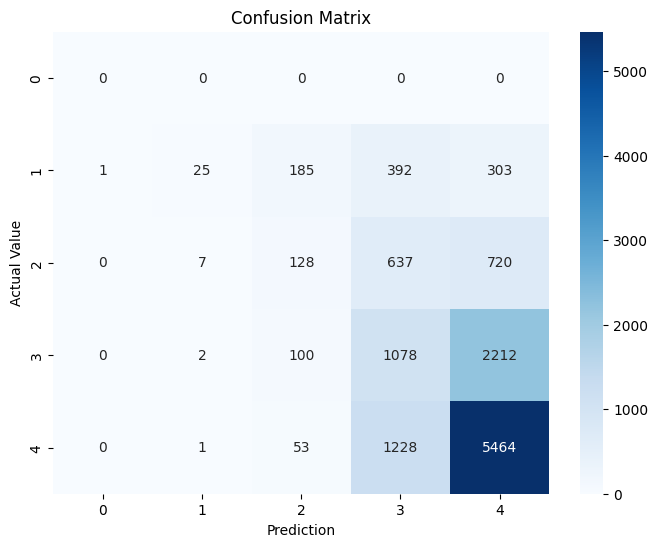

array([[   0,    0,    0,    0,    0],
       [   1,   25,  185,  392,  303],
       [   0,    7,  128,  637,  720],
       [   0,    2,  100, 1078, 2212],
       [   0,    1,   53, 1228, 5464]])

In [35]:
prediction=modelo_final_nn.predict(X_test)

score_metrics("Neural Networks",prediction,y_test,mejores_parametros,folder="tunned_predictions")

### KNN Regressor

In [36]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for KNN
params_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],  # Uniform: same weight; Distance: closer = more important
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]  # 1 = Manhattan, 2 = Euclidean
}

# Create KNN regressor
knn = KNeighborsRegressor()

# GridSearchCV to find best hyperparameters
knn_search = GridSearchCV(knn, param_grid=params_knn, cv=5, verbose=2, n_jobs=-1)

# Train model
knn_search.fit(X_muestra, y_muestra)


Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV] END algorithm=auto, n_neighbors=3, p=2, weights=uniform; total time=   0.1s
[CV] END algorithm=auto, n_neighbors=3, p=1, weights=distance; total time=   0.2s
[CV] END algorithm=auto, n_neighbors=3, p=1, weights=uniform; total time=   0.4s
[CV] END algorithm=auto, n_neighbors=3, p=2, weights=uniform; total time=   0.1s
[CV] END algorithm=auto, n_neighbors=3, p=1, weights=distance; total time=   0.3s
[CV] END algorithm=auto, n_neighbors=3, p=2, weights=uniform; total time=   0.1s
[CV] END algorithm=auto, n_neighbors=3, p=2, weights=distance; total time=   0.1s
[CV] END algorithm=auto, n_neighbors=3, p=2, weights=distance; total time=   0.1s
[CV] END algorithm=auto, n_neighbors=3, p=2, weights=distance; total time=   0.2s
[CV] END algorithm=auto, n_neighbors=5, p=1, weights=uniform; total time=   0.3s
[CV] END algorithm=auto, n_neighbors=3, p=2, weights=uniform; total time=   0.1s
[CV] END algorithm=auto, n_neighbors=5, p=

GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 5, 7, 9, 11], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             verbose=2)

In [37]:
mejores_parametros = knn_search.best_params_
mejores_parametros

{'algorithm': 'auto', 'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}

In [38]:
# Crear el modelo final con los mejores parámetros
modelo_final_knn = KNeighborsRegressor(**mejores_parametros)

# Entrenar el modelo con todo el dataset
modelo_final_knn.fit(X_train, y_train)


KNeighborsRegressor(n_neighbors=11, p=1)


+---------------------------------------------------+
        KNN Regressor - Regression Model Evaluation                         
+---------------------------------------------------+
    MAE  (Mean Absolute Error): 0.7838
    MSE  (Mean Squared Error): 1.1241
    RMSE (Root Mean Squared Error): 1.0602
    R² Score (Coefficient of Determination): 0.0886
    Threshold used: 0.5
+---------------------------------------------------+
    


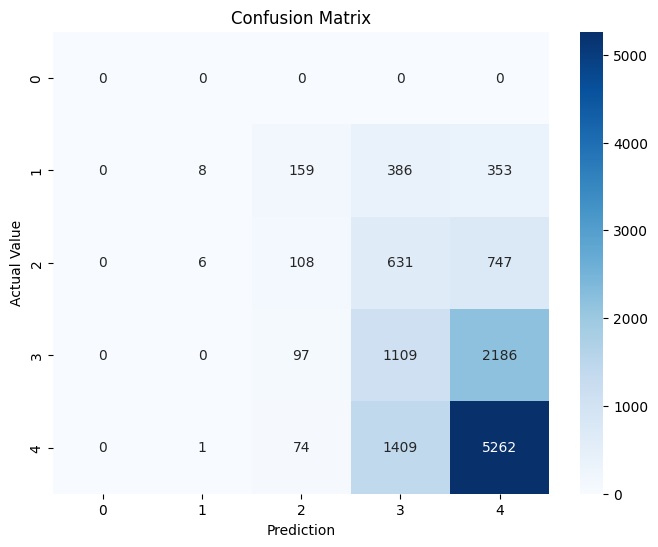

array([[   0,    0,    0,    0,    0],
       [   0,    8,  159,  386,  353],
       [   0,    6,  108,  631,  747],
       [   0,    0,   97, 1109, 2186],
       [   0,    1,   74, 1409, 5262]])

In [39]:
prediction=modelo_final_knn.predict(X_test)

score_metrics("KNN Regressor",prediction,y_test,mejores_parametros,folder="tunned_predictions")

## Final results

To see the final results, lets load all the files generated and plot the metrics

In [52]:
import numpy as np
import pandas as pd
import glob
import os

# Folder name
folder = 'baseline'

# Get all *_predictions.csv files inside the folder
prediction_files = glob.glob(os.path.join(folder, "*_predictions.csv"))

# Iterate over the prediction files
for file in prediction_files:
    # Extract the algorithm name from the file name
    algorithm = os.path.basename(file).replace("_predictions.csv", "")
    
    # Load predictions from the CSV file, considering it has headers
    predictions_df = pd.read_csv(file)  # Read CSV as DataFrame
    
    # Assuming the first column contains the predictions
    predictions = predictions_df.iloc[:, 0].values.flatten()  # Convert to 1D array
    if len(y_test)==len(predictions):
        # Call the function with the specified parameters
        score_metrics(algorithm, predictions, y_test, parameters=None,print_res=False)
    else:
        print(algorithm)


In [53]:
prediction_files

['baseline/XGBoost_predictions.csv',
 'baseline/Neural_Network_predictions.csv',
 'baseline/KNN_Regressor_predictions.csv',
 'baseline/Decision_Tree_predictions.csv',
 'baseline/Linear_Regression_predictions.csv',
 'baseline/Random_Forest_predictions.csv']

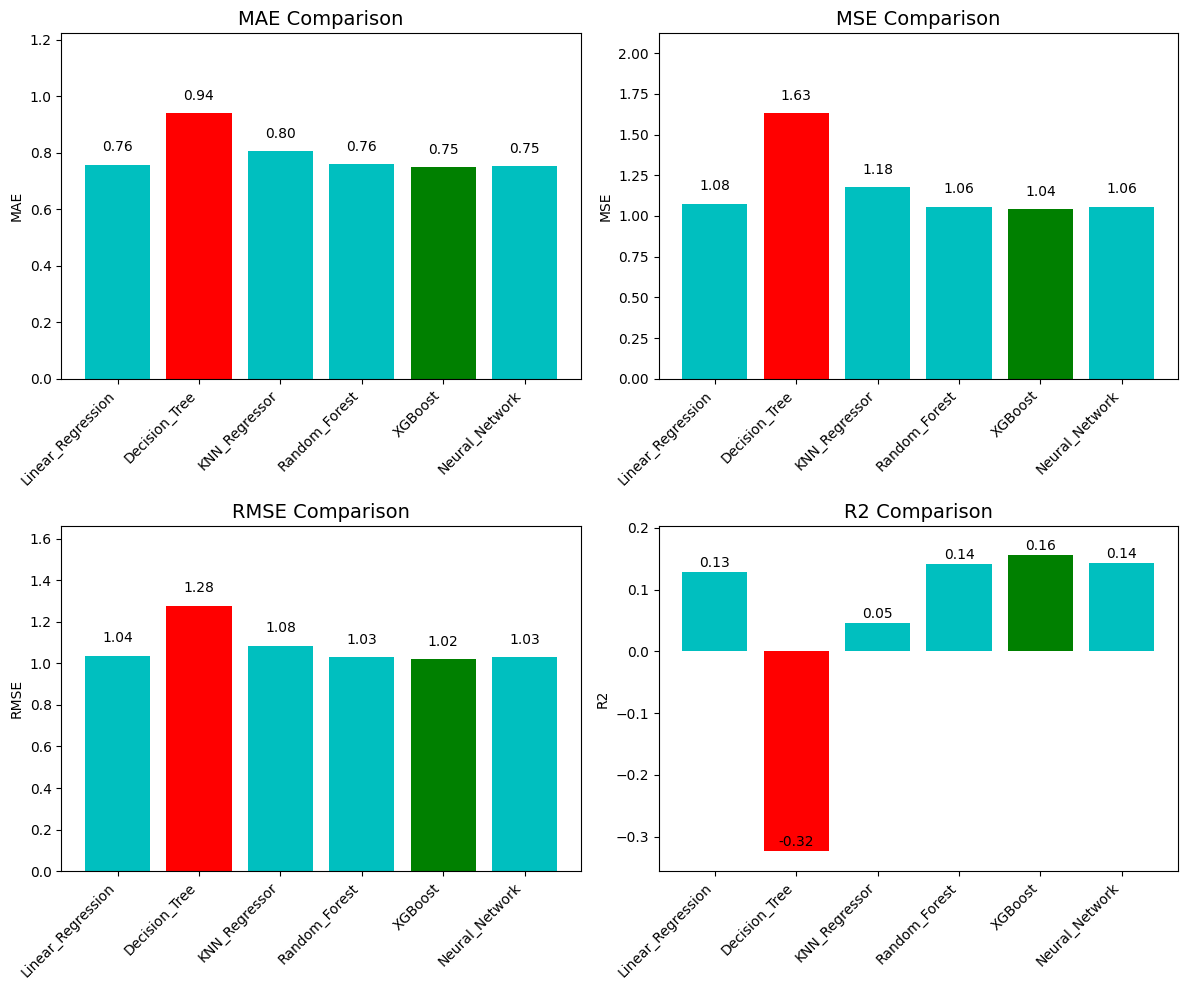

In [54]:

# Select the metrics to plot
metrics = ["MAE", "MSE", "RMSE", "R2"]
algorithms = ["Linear_Regression","Decision_Tree","KNN_Regressor", "Random_Forest", "XGBoost","Neural_Network"]

# Extract values for each metric
values = {metric: [scores[algo][metric] for algo in algorithms] for metric in metrics}

# Create a 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten to iterate easily

for i, metric in enumerate(metrics):
    metric_values = values[metric]

    # Find indices of best and worst models
    best_index = np.argmax(metric_values) if metric == "R2" else np.argmin(metric_values)
    worst_index = np.argmin(metric_values) if metric == "R2" else np.argmax(metric_values)

    # Default color for bars
    colors = ['c'] * len(algorithms)
    colors[best_index] = 'green'  # Best model
    colors[worst_index] = 'red'  # Worst model

    # Create bar plot
    axes[i].bar(algorithms, metric_values, color=colors)
    axes[i].set_title(f"{metric} Comparison", fontsize=14)
    axes[i].set_ylabel(metric)
    axes[i].set_ylim(min(metric_values)*1.1 if min(metric_values)<0 else 0, abs(max(metric_values) * 1.3) ) # Adjust y-axis for better visibility
    axes[i].set_xticks(range(len(algorithms)))
    axes[i].set_xticklabels(algorithms, rotation=45, ha="right")

    # Annotate best and worst values
    for j, val in enumerate(metric_values):
        axes[i].text(j, val + (max(metric_values) * 0.05), f"{val:.2f}", ha='center', fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [55]:
import numpy as np
import pandas as pd
import glob
import os

# Folder name
folder = 'tunned_predictions'

# Get all *_predictions.csv files inside the folder
prediction_files = glob.glob(os.path.join(folder, "*_predictions.csv"))

# Iterate over the prediction files
for file in prediction_files:
    # Extract the algorithm name from the file name
    algorithm = os.path.basename(file).replace("_predictions.csv", "")
    
    # Load predictions from the CSV file, considering it has headers
    predictions_df = pd.read_csv(file)  # Read CSV as DataFrame
    
    # Assuming the first column contains the predictions
    predictions = predictions_df.iloc[:, 0].values.flatten()  # Convert to 1D array
    if len(y_test)==len(predictions):
        # Call the function with the specified parameters
        score_metrics(algorithm, predictions, y_test, parameters=None,print_res=False)
    else:
        print(algorithm)


In [56]:
prediction_files

['tunned_predictions/XGBoost_predictions.csv',
 'tunned_predictions/Decision_Tree_predictions.csv',
 'tunned_predictions/Linear Regression_predictions.csv',
 'tunned_predictions/KNN Regressor_predictions.csv',
 'tunned_predictions/Neural Networks_predictions.csv',
 'tunned_predictions/Random_Forest_predictions.csv']

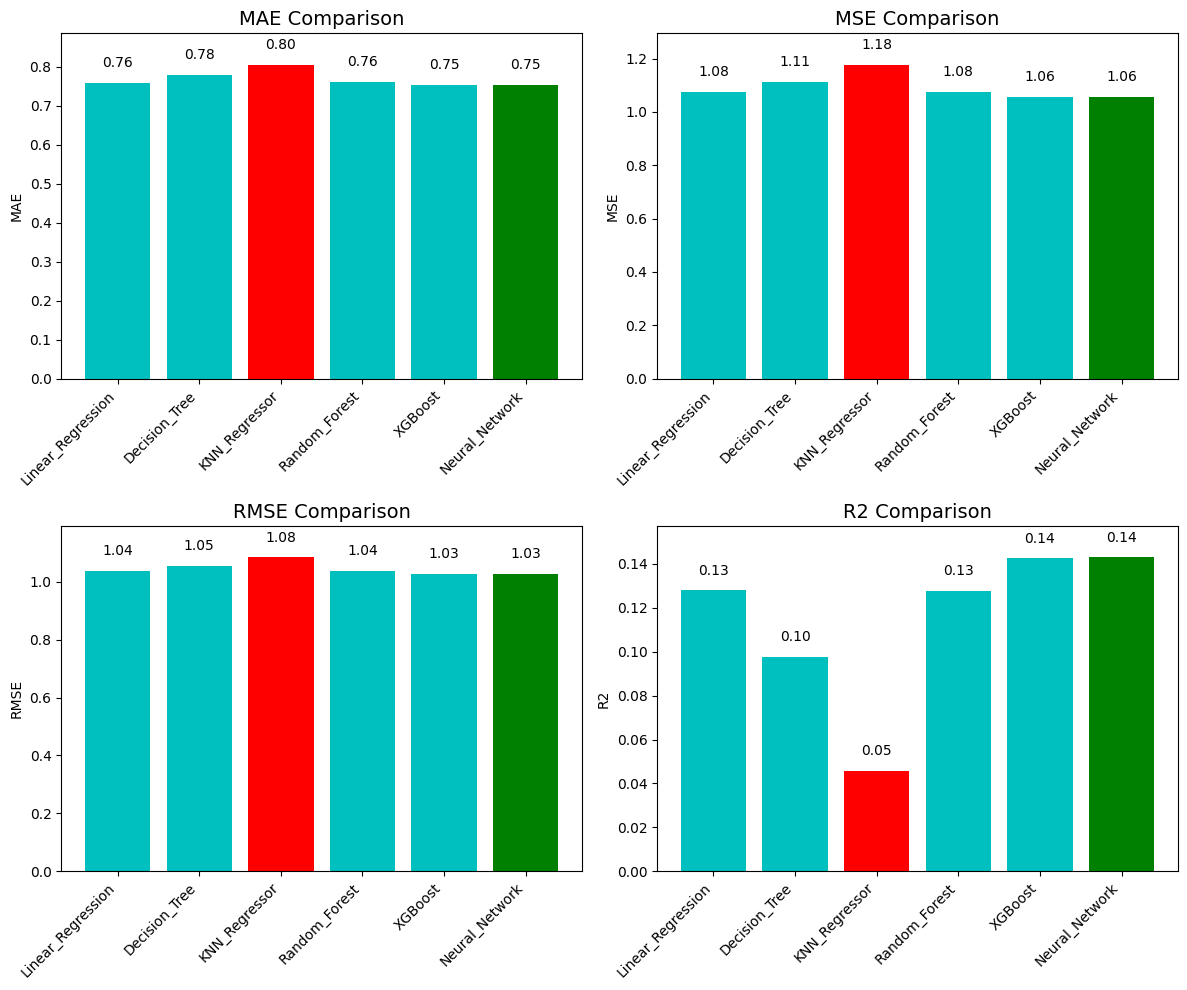

In [57]:

# Select the metrics to plot
metrics = ["MAE", "MSE", "RMSE", "R2"]
algorithms = ["Linear_Regression","Decision_Tree","KNN_Regressor", "Random_Forest", "XGBoost","Neural_Network"]

# Extract values for each metric
values = {metric: [scores[algo][metric] for algo in algorithms] for metric in metrics}

# Create a 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten to iterate easily

for i, metric in enumerate(metrics):
    metric_values = values[metric]

    # Find indices of best and worst models
    best_index = np.argmax(metric_values) if metric == "R2" else np.argmin(metric_values)
    worst_index = np.argmin(metric_values) if metric == "R2" else np.argmax(metric_values)

    # Default color for bars
    colors = ['c'] * len(algorithms)
    colors[best_index] = 'green'  # Best model
    colors[worst_index] = 'red'  # Worst model

    # Create bar plot
    axes[i].bar(algorithms, metric_values, color=colors)
    axes[i].set_title(f"{metric} Comparison", fontsize=14)
    axes[i].set_ylabel(metric)
    axes[i].set_ylim(min(metric_values)*1.1 if min(metric_values)<0 else 0, abs(max(metric_values) * 1.1) ) # Adjust y-axis for better visibility
    axes[i].set_xticks(range(len(algorithms)))
    axes[i].set_xticklabels(algorithms, rotation=45, ha="right")

    # Annotate best and worst values
    for j, val in enumerate(metric_values):
        axes[i].text(j, val + (max(metric_values) * 0.05), f"{val:.2f}", ha='center', fontsize=10)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## PREDICTION

In [58]:
from model import Model
params={'booster': 'gbtree',
 'eta': 0.05,
 'eval_metric': 'rmse',
 'max_depth': 6,
 'objective': 'reg:squarederror',
 'random_state': 2,
 'reg_alpha': 2.5,
 'subsample': 0.6}


model=Model(modelo_final_xg)
model.predict("zsnOyEeNpzscqqc35Y8pcw","pum7TsURcc2NKcYKpId9gA")

XGBoostError: [21:05:28] /workspace/src/predictor/cpu_predictor.cc:779: Check failed: m->NumColumns() == model.learner_model_param->num_feature (1 vs. 40) : Number of columns in data must equal to trained model.
Stack trace:
  [bt] (0) /home/jaume/miniconda3/envs/cml_env/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x2a6acc) [0x780f0caa6acc]
  [bt] (1) /home/jaume/miniconda3/envs/cml_env/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x87d340) [0x780f0d07d340]
  [bt] (2) /home/jaume/miniconda3/envs/cml_env/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x87faa0) [0x780f0d07faa0]
  [bt] (3) /home/jaume/miniconda3/envs/cml_env/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x637288) [0x780f0ce37288]
  [bt] (4) /home/jaume/miniconda3/envs/cml_env/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x68d2f9) [0x780f0ce8d2f9]
  [bt] (5) /home/jaume/miniconda3/envs/cml_env/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x1bacdc) [0x780f0c9bacdc]
  [bt] (6) /home/jaume/miniconda3/envs/cml_env/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(XGBoosterPredictFromDense+0x116) [0x780f0c9bb266]
  [bt] (7) /home/jaume/miniconda3/envs/cml_env/lib/python3.10/lib-dynload/../../libffi.so.8(+0xa052) [0x780fbe460052]
  [bt] (8) /home/jaume/miniconda3/envs/cml_env/lib/python3.10/lib-dynload/../../libffi.so.8(+0x8925) [0x780fbe45e925]

